In [1]:
%matplotlib inline
import os
import time
import numpy
import pandas as pd
import matplotlib

In [61]:
# Example of coupled execution
# log_files = {'new': 'slurm-4240.out'}

# Example of completed uncoupled, with bad node?
log_files = {'new': 'slurm-4457.out'}

# Example of completed uncoupled, without bad node?
log_files = {'new': 'slurm-4459.out'}

log_files = {'new': 'slurm-4834.out'}

log_files = {'8': 'slurm-8662673.out', '32': 'slurm-8664294.out'}

# log_files = {'before': 'slurm-5196.out', 'after': 'slurm-5204.out'}
log_files = {'after': 'slurm-5206.out', 'afterafter': 'slurm-5207.out', 'many-buffered': 'slurm-5208.out'}

log_files = {'before': 'slurm-5206.out', 'after': 'slurm-5210.out'}

log_files = {'r01n07': 'slurm-5218.out', 'ref': 'slurm-5219.out'}

log_files = {'8': 'slurm-8691730.out', '32': 'slurm-8691789.out'}

log_files = {'256': 'slurm-8752267.out'}

log_files = {'256': 'slurm-8938366.out'}

# log_files = {'new': 'slurm-4236.out'}
# log_files = {1: 'slurm-3600.out', 4: 'slurm-3601.out', 16: 'slurm-3602.out', 'rwlock': 'slurm-4235.out'}

In [69]:
 def log_file_to_dataframe(log_file):
    fp = open(log_file, 'r')
    perf_records = []
    line_no = 1
    for line in fp:
        if line.startswith('PE ') and line.find('- total') != -1:
            try:
                tokens = line.split()

                # Sample line in log file:
                #   PE 6 - total 1336.802000 ms - metadata 54.481000 ms (50.733000 0.000000) - \
                #     summary 3.805000 ms (1.763000 0.072000 1.970000 | 0.065000 0.037000 0.048000 1.820000) - \
                #     edges 1278.047000 ms (1190.644000 80.641000) - neighbor updates 0.411000 ms - \
                #     abort 0.058000 ms - 0 spins - 9 / 16 PE neighbors  - partition window = , 1522 / 28900 active - \
                #     aborting? 0 - last step? 0 - remote cache hits=6688 misses=3553 age misses=0, feature cache hits=0 misses=0
                #
                # Sample new line in log file:
                #   PE 11 - total 42.046000 ms - metadata 26.715000 ms (26.212000 0.000000) - \
                #     summary 4.765000 ms (0.133000 0.023000 4.609000 | 1.428000 1.406000 1.281000 0.481000) - \
                #     edges 10.411000 ms (2.730000 7.445000) - neighbor updates 0.111000 ms - coupling 0.020000 ms - \
                #     throttling 0.024000 ms - 0 spins - 6 / 256 PE neighbors  - partition window = , 43 / 10000 active - \
                #     aborting? 0 - last step? 0 - remote cache hits=1611 misses=375 age misses=0, feature cache hits=0 misses=0
                index = 1
                pe = int(tokens[index])
                index += 3

                timestep = int(tokens[index])
                index += 3

                total = float(tokens[index])
                index += 4

                metadata = float(tokens[index])
                index += 6

                summary = float(tokens[index])
                index += 2
                summary_actor_partitions = float(tokens[index][1:])
                index += 1
                summary_time_window = float(tokens[index])
                index += 1
                summary_update_neighbors = float(tokens[index][:-1])
                index += 3

                edges = float(tokens[index])
                index += 2
                edges_updates = float(tokens[index][1:])
                index += 1
                edges_getmem = float(tokens[index])
                index += 1
                edges_checks = float(tokens[index][:-1])
                index += 4
                

                neighbor_updates = float(tokens[index])
                index  += 5

                coupled_values = float(tokens[index])
                index += 4

                coupling = float(tokens[index])
                index += 2

                n_coupled_spins_str = tokens[index]
                n_coupled_spins_str = n_coupled_spins_str[1:]
                n_coupled_spins_str = n_coupled_spins_str[:len(n_coupled_spins_str) - 1]
                n_coupled_spins = int(n_coupled_spins_str)
                index += 3

                throttling = float(tokens[index])
                index += 3

                spins = int(tokens[index])
                index += 3

                n_neighbors = int(tokens[index])
                index += 10

                active_partitions = int(tokens[index])
                index += 14

                cache_hits_str = tokens[index]
                cache_hits = int(cache_hits_str.split('=')[1])
                index += 1

                cache_misses_str = tokens[index]
                cache_misses = int(cache_misses_str.split('=')[1])
                index += 2

                cache_age_misses_str = tokens[index]
                cache_age_misses_str = cache_age_misses_str.split('=')[1]
                cache_age_misses_str = cache_age_misses_str[:-1]
                cache_age_misses = int(cache_age_misses_str)
                index += 5
                
                quiets_str = tokens[index]
                quiets_str = quiets_str.split('=')[1]
                nquiets = int(quiets_str)

                perf_records.append({'pe': pe,
                                     'timestep': timestep,
                                     'total': total,
                                     'metadata': metadata,
                                     'summary': summary,
                                     'summary_actor_partitions': summary_actor_partitions,
                                     'summary_time_window': summary_time_window,
                                     'summary_update_neighbors': summary_update_neighbors,
                                     'edges': edges,
                                     'edges_updates': edges_updates,
                                     'edges_getmem': edges_getmem,
                                     'edges_checks': edges_checks,
                                     'neighbor_updates': neighbor_updates,
                                     'coupling': coupling,
                                     'n_coupled_spins': n_coupled_spins,
                                     'coupled_values': coupled_values,
                                     'throttling': throttling,
                                     'spins': spins,
                                     'n_neighbors': n_neighbors,
                                     'active_partitions': active_partitions,
                                     'cache_hits': cache_hits,
                                     'cache_misses': cache_misses,
                                     'cache_age_misses': cache_age_misses,
                                     'nquiets': nquiets})
            except Exception as e:
                # Ignore invalid lines that may arise from interleaved output.
                # Assume this isn't going to corrupt too much of our data
                print('Exception ' + str(e) + ' on line ' + str(line_no))
        line_no += 1
    fp.close()
    return pd.DataFrame(perf_records)

In [70]:
import matplotlib.pyplot as plt
def compare_dist(cols, sep_plots = False, logy = False):
    if sep_plots:
        fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize = (20.0, 6.0))
        
        min_val = None
        max_val = None
        for column in cols:
            for nnodes in sorted(dfs.keys()):
                minimum = dfs[nnodes][column].min()
                maximum = dfs[nnodes][column].max()
                if min_val is None or minimum < min_val:
                    min_val = minimum
                if max_val is None or maximum > max_val:
                    max_val = maximum

        nbins = 100
        bins = range(int(min_val), int(max_val), int((max_val - min_val) / nbins))
        
        count = 0
        for column in cols:
            series = {}
            for nnodes in sorted(dfs.keys()):
                series[nnodes + '-' + column] = dfs[nnodes][column]
                nsamples = dfs[nnodes][column].dropna().count()
                print(str(nsamples) + ' samples for ' + nnodes + ' - ' + column)
            
            pd.DataFrame(series).plot(kind = 'hist', bins = bins, ax = axes[count], logy = logy, alpha = 0.4)
            count += 1
            
        min_ylim = None
        max_ylim = None
        min_xlim = None
        max_xlim = None
        for ax in axes:
            limits = ax.get_ylim()
            if min_ylim is None or limits[0] < min_ylim:
                min_ylim = limits[0]
            if max_ylim is None or limits[1] > max_ylim:
                max_ylim = limits[1]
                
            limits = ax.get_xlim()
            if min_xlim is None or limits[0] < min_xlim:
                min_xlim = limits[0]
            if max_xlim is None or limits[1] > max_xlim:
                max_xlim = limits[1]
        for ax in axes:
            ax.set_ylim((min_ylim, max_ylim))
            ax.set_xlim((min_xlim, max_xlim))
    else:
        series = {}
        for nnodes in sorted(dfs.keys()):
            for column in cols:
                series[nnodes + '-' + column] = dfs[nnodes][column]

        fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
        pd.DataFrame(series).plot(kind = 'hist', bins = 100, ax = ax, logy = logy, alpha = 0.4)

In [71]:
dfs = {}
for nnodes in log_files:
    dfs[nnodes] = log_file_to_dataframe(log_files[nnodes])

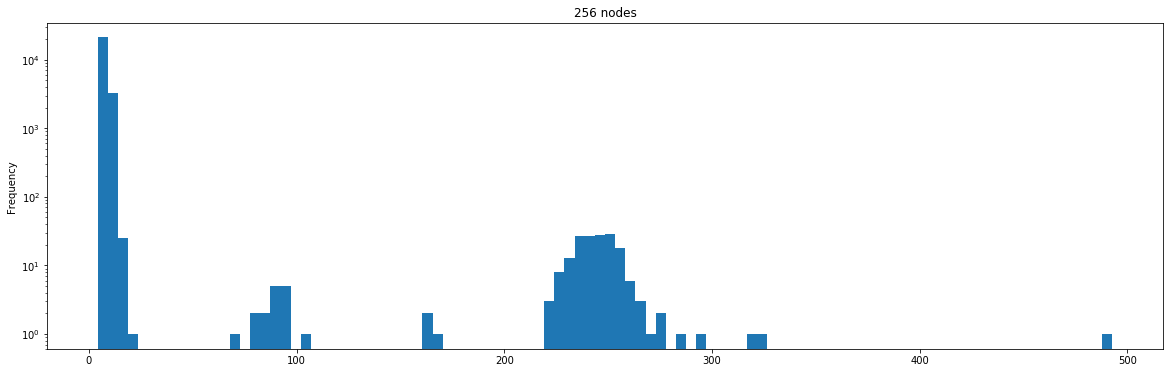

In [72]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['total'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes', logy = True)

24576 samples for 256 - summary
24576 samples for 256 - total


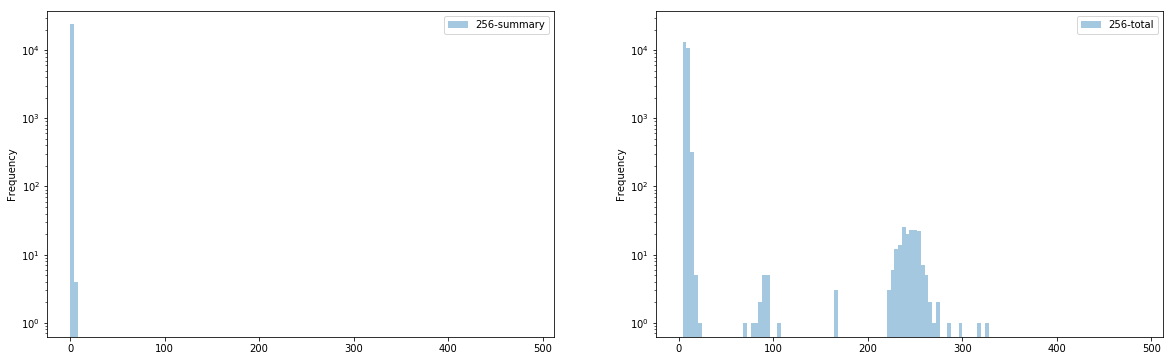

In [74]:
# for nnodes in sorted(dfs.keys()):
#     fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
#     dfs[nnodes]['summary'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes), logy = True)
    
compare_dist(['summary', 'total'], sep_plots = True, logy = True)

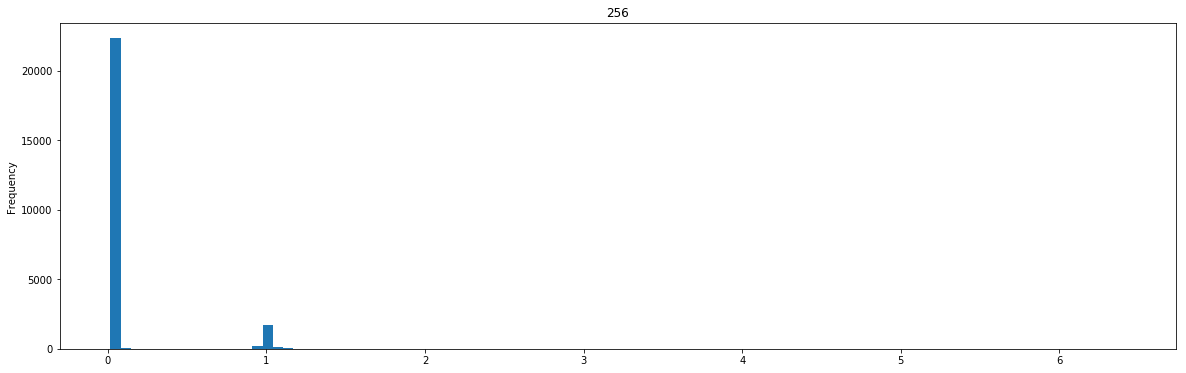

In [75]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['summary_actor_partitions'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes))

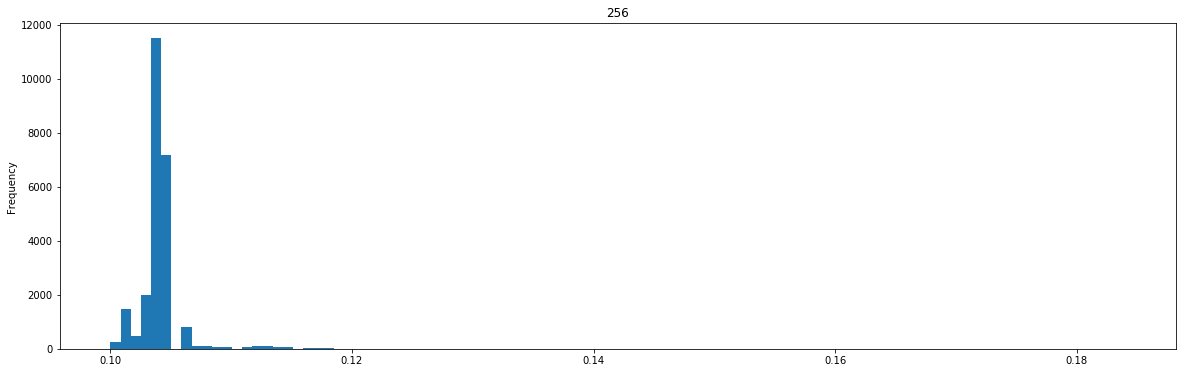

In [76]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['summary_time_window'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes))

24576 samples for 256 - summary_update_neighbors
24576 samples for 256 - summary
24576 samples for 256 - total


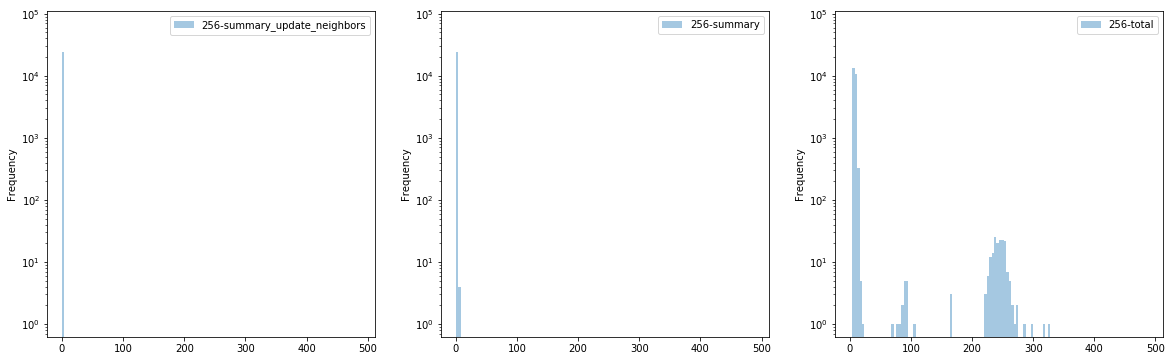

In [78]:
# for nnodes in sorted(dfs.keys()):
#     fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
#     dfs[nnodes]['summary_update_neighbors'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes))
    
compare_dist(['summary_update_neighbors', 'summary', 'total'], sep_plots = True, logy = True)

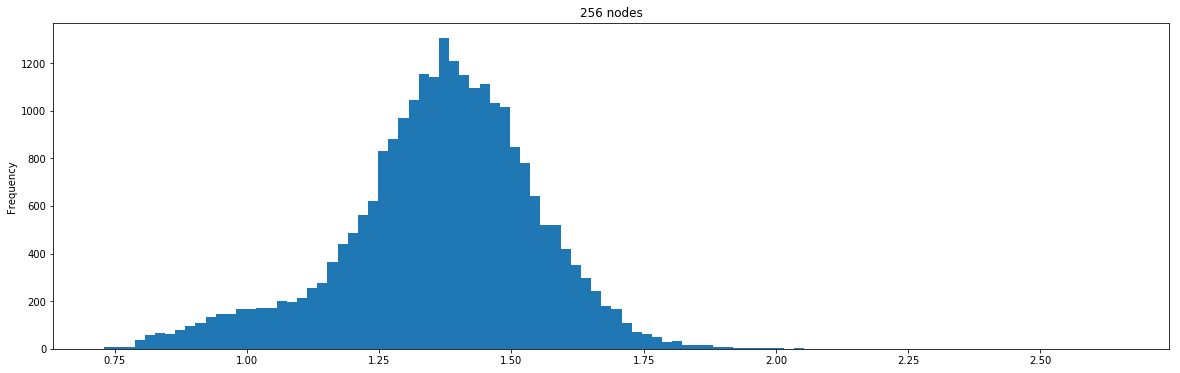

In [80]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['metadata'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

In [81]:
dfs['256']['n_neighbors'].value_counts()

15    9883
20    4230
25    4132
12    1609
21     870
24     835
19     779
10     643
16     314
22     305
9      235
23     193
17     150
18     114
8      109
11      69
14      55
13      35
6       16
Name: n_neighbors, dtype: int64

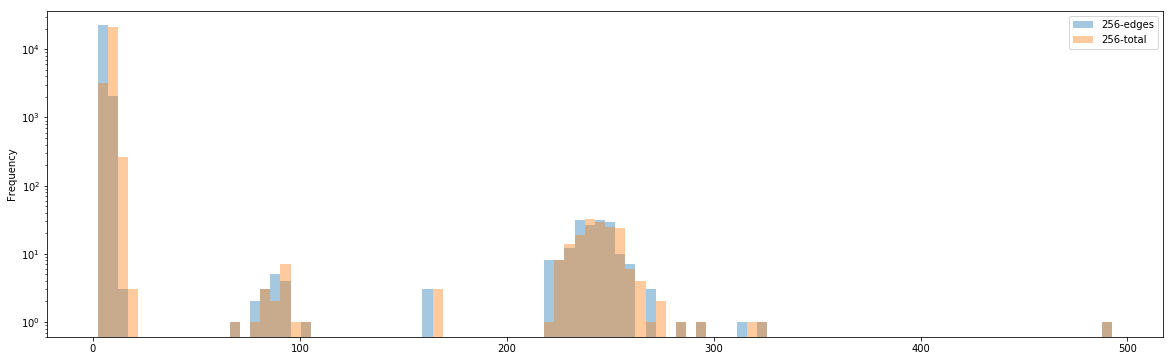

In [83]:
# for nnodes in sorted(dfs.keys()):
#     fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
#     dfs[nnodes]['edges'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes', logy = True)
    
compare_dist(['edges', 'total'], logy = True)

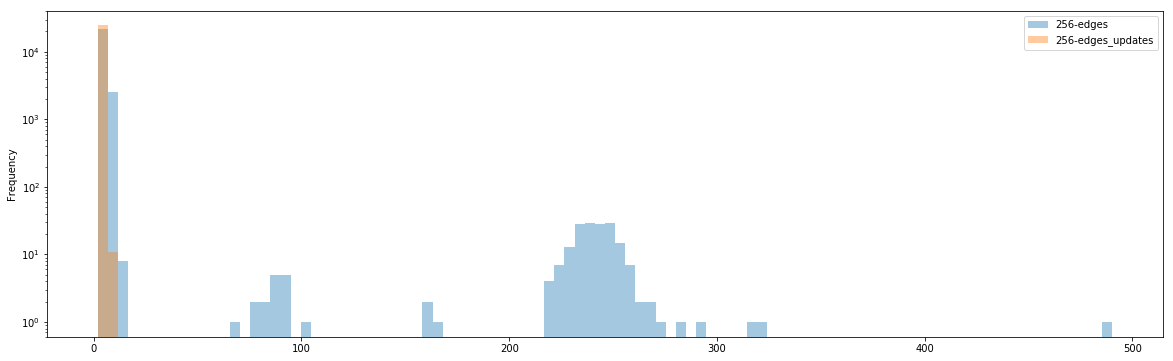

In [90]:
compare_dist(['edges', 'edges_updates'], logy = True)

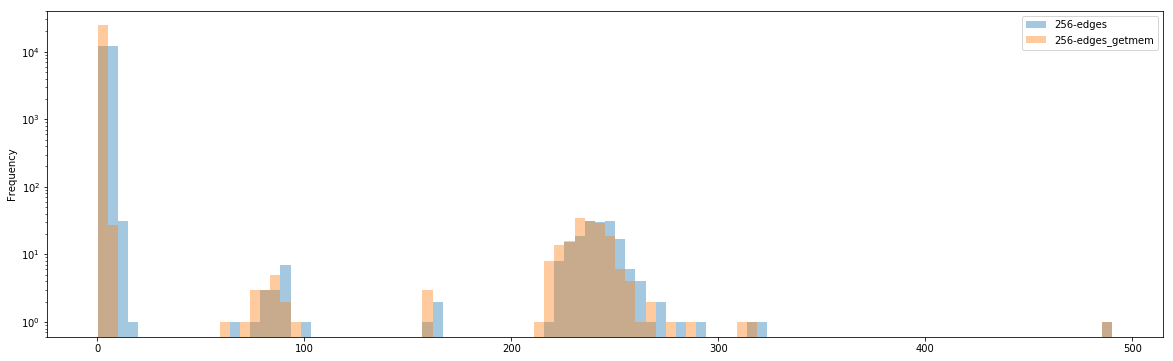

In [91]:
compare_dist(['edges', 'edges_getmem'], logy = True)

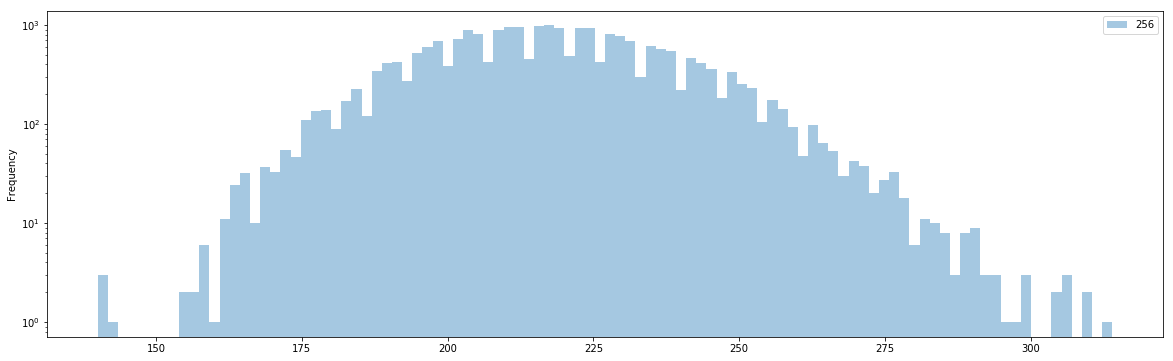

In [84]:
#for nnodes in sorted(dfs.keys()):
#    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
#    dfs[nnodes]['nquiets'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')
    
series = {}
for nnodes in sorted(dfs.keys()):
    series[nnodes] = dfs[nnodes]['nquiets']
   
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
pd.DataFrame(series).plot(kind = 'hist', bins = 100, ax = ax, logy = True, alpha = 0.4)

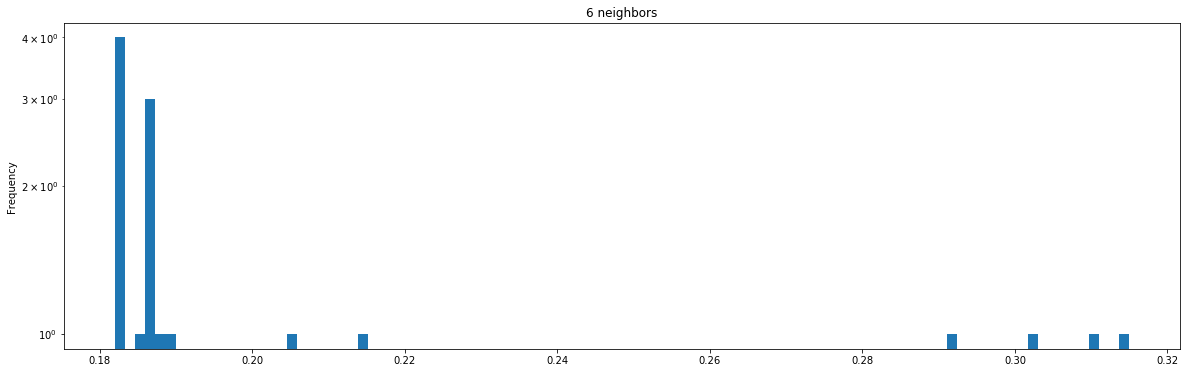

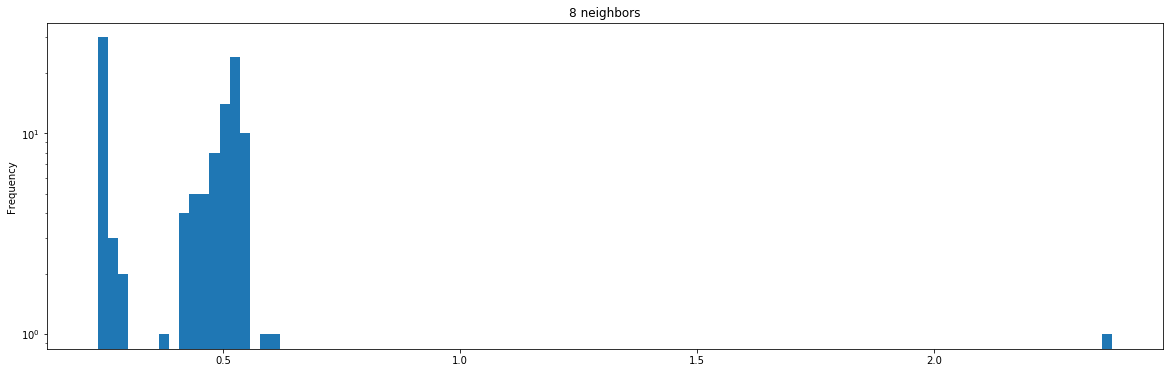

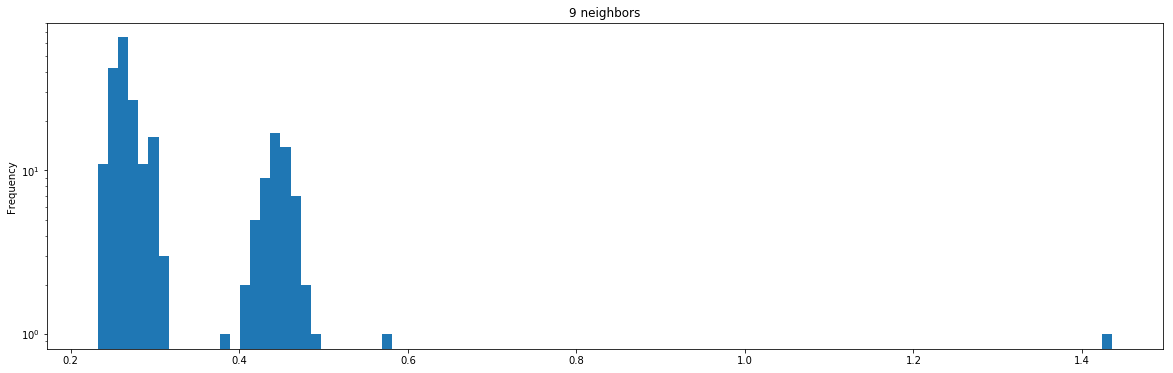

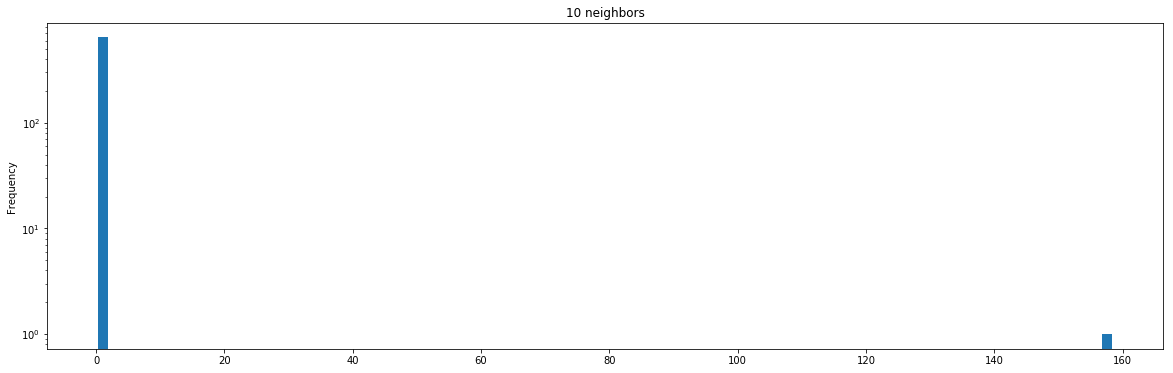

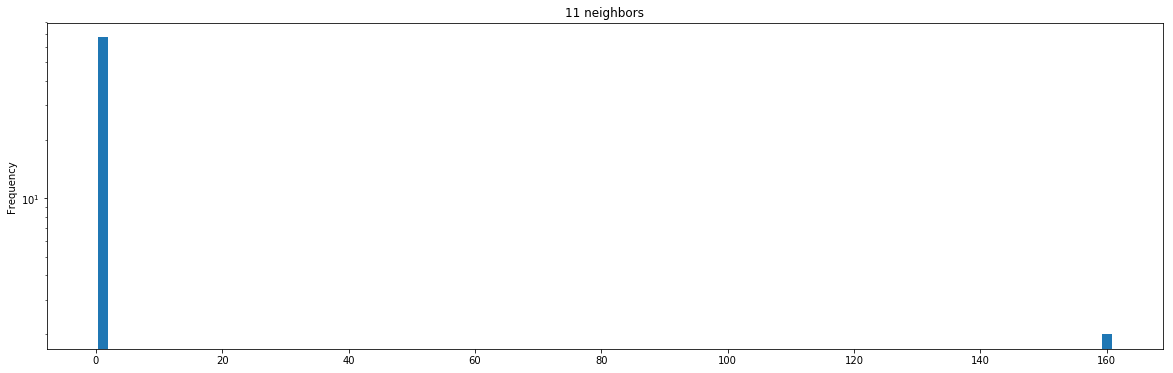

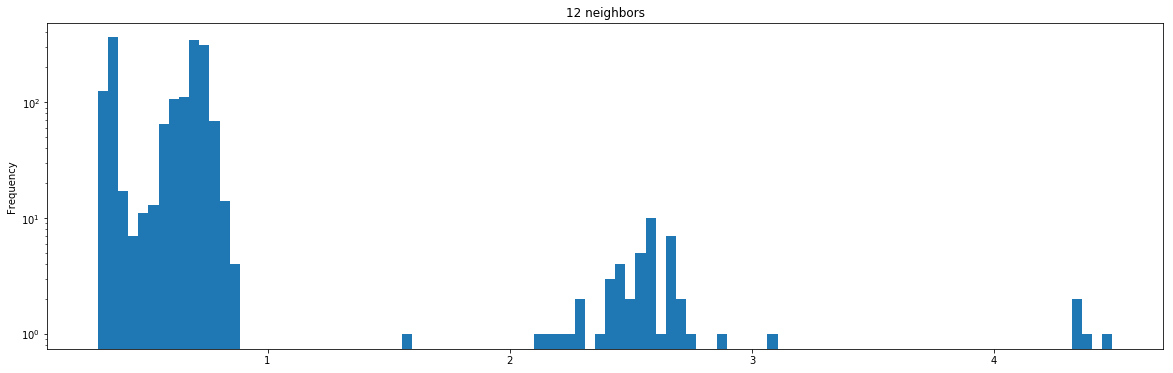

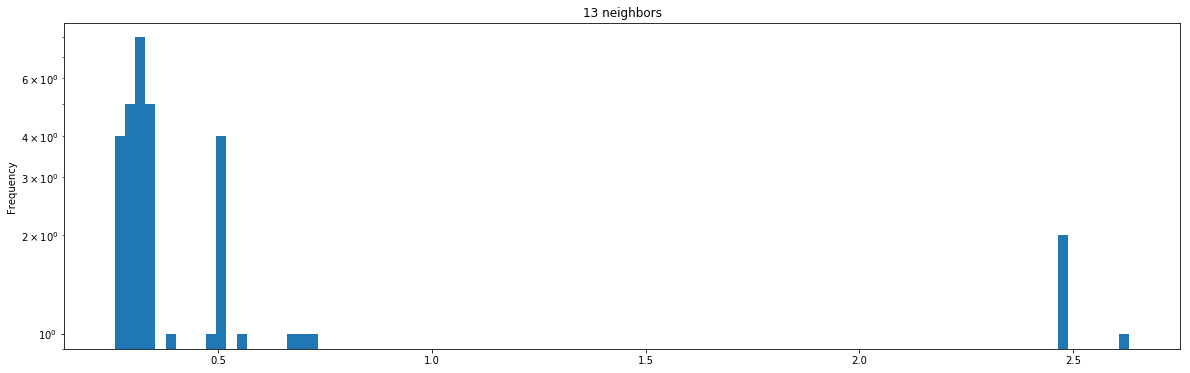

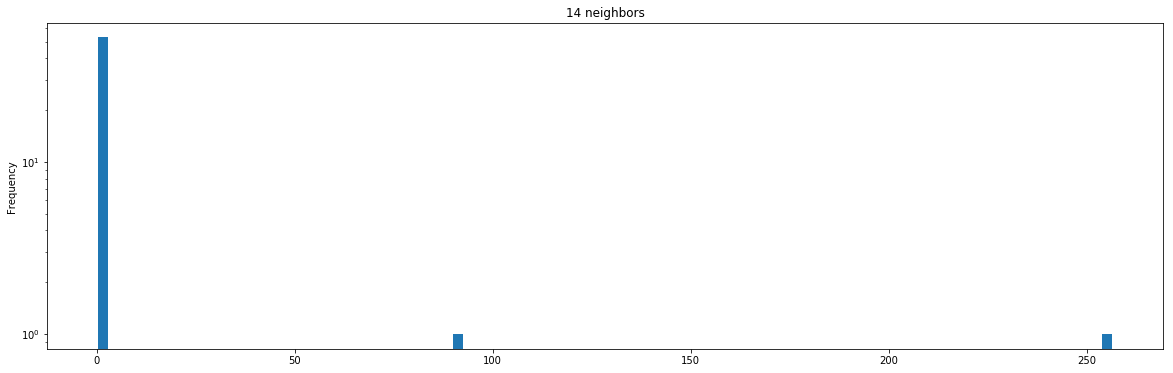

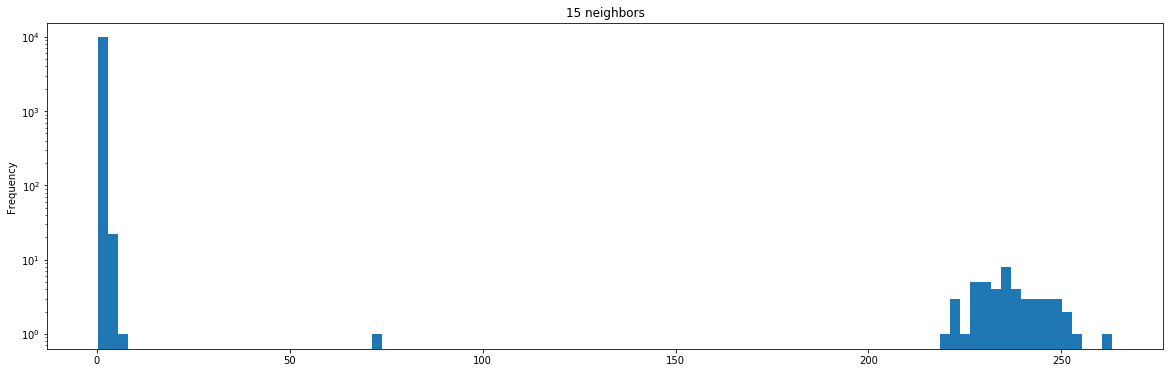

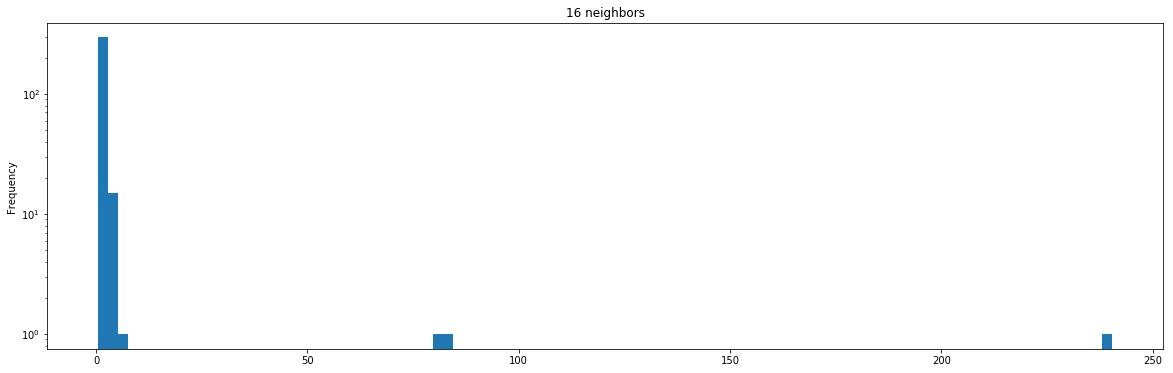

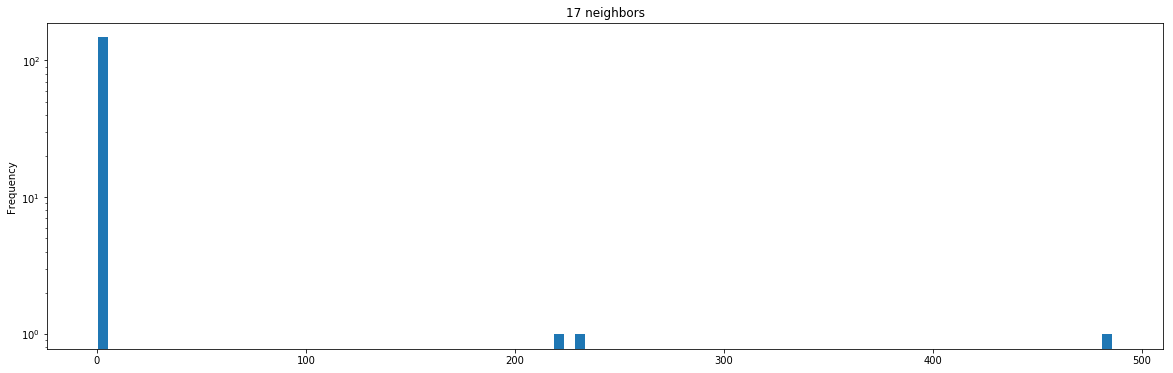

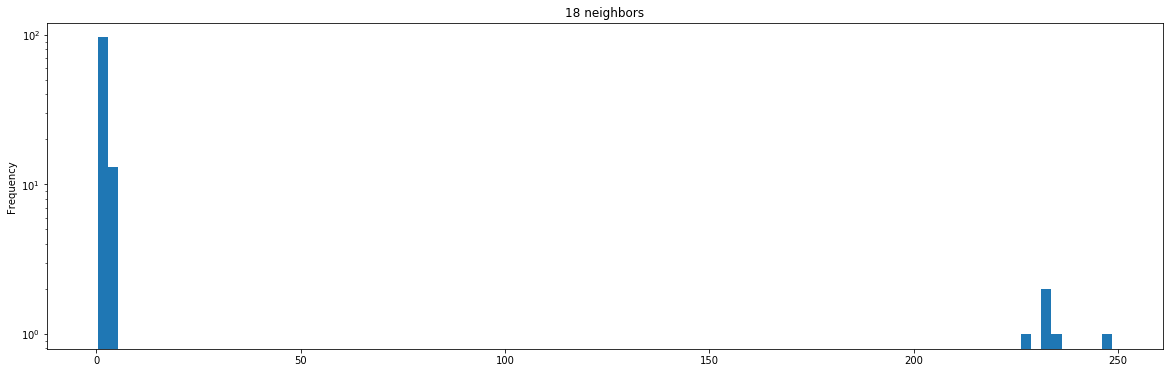

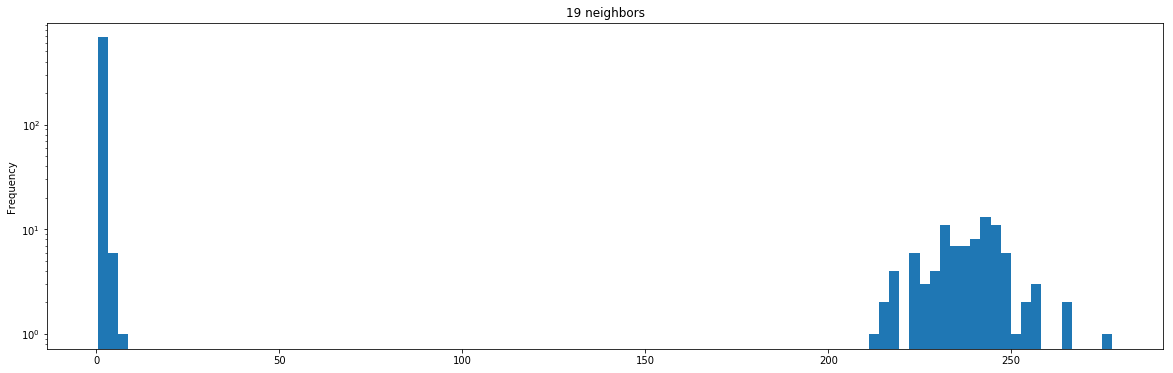

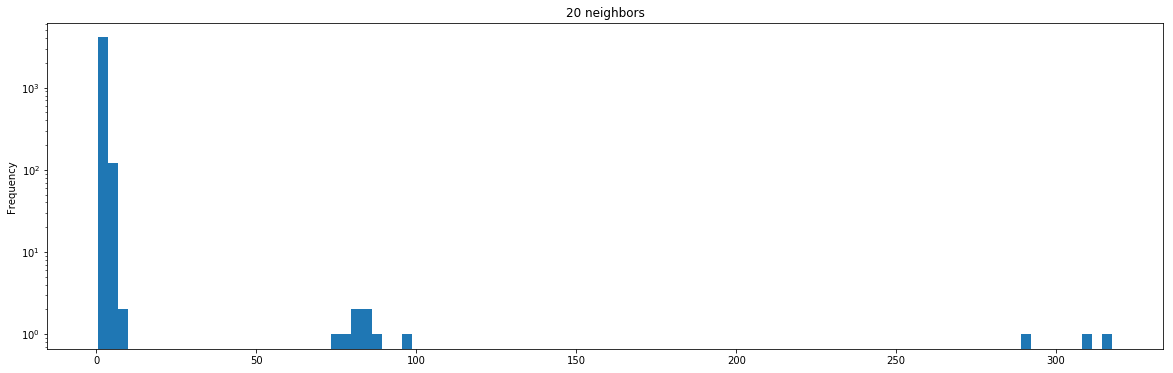

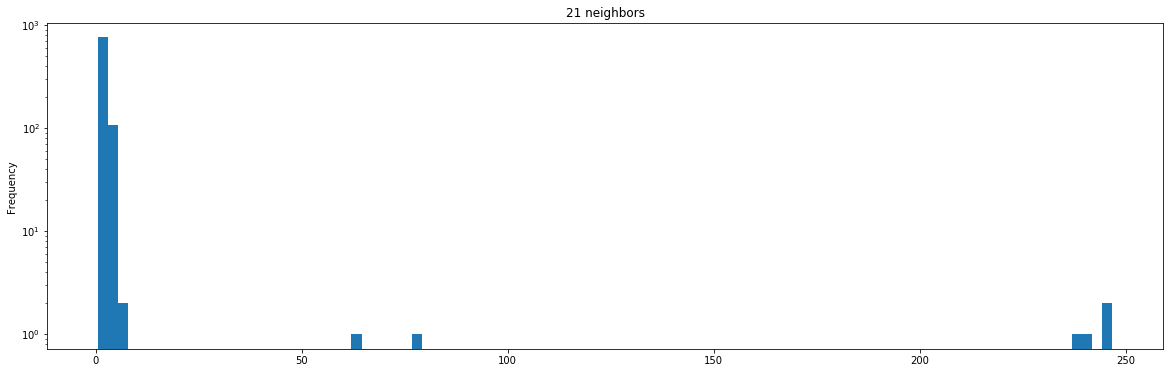

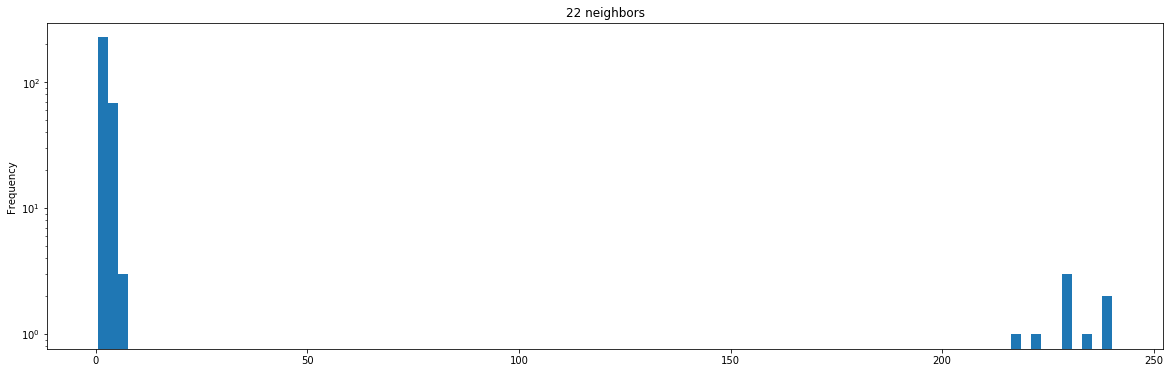

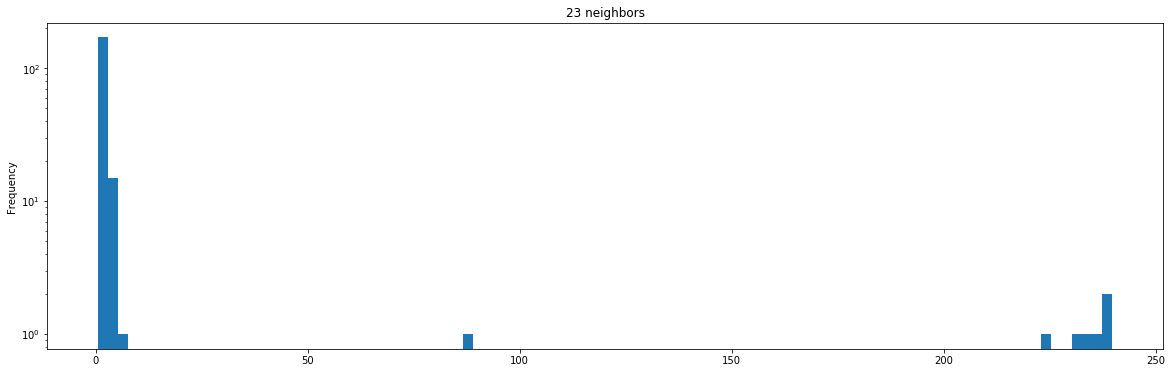

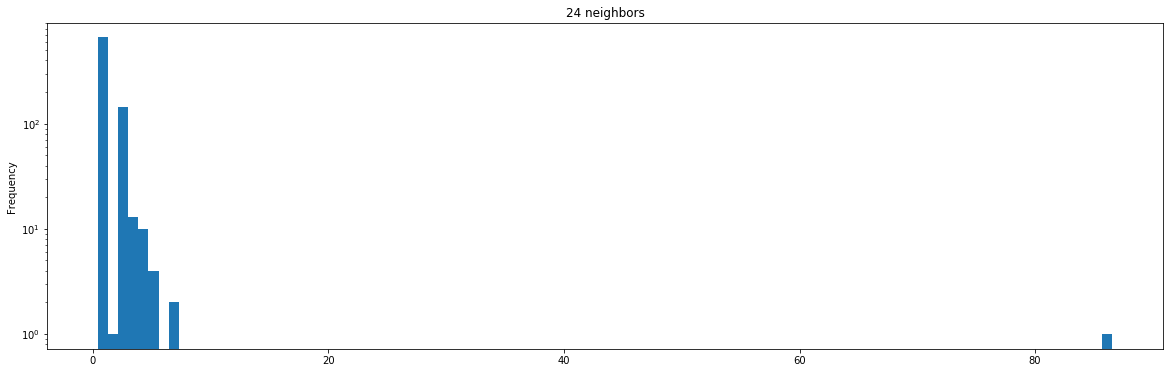

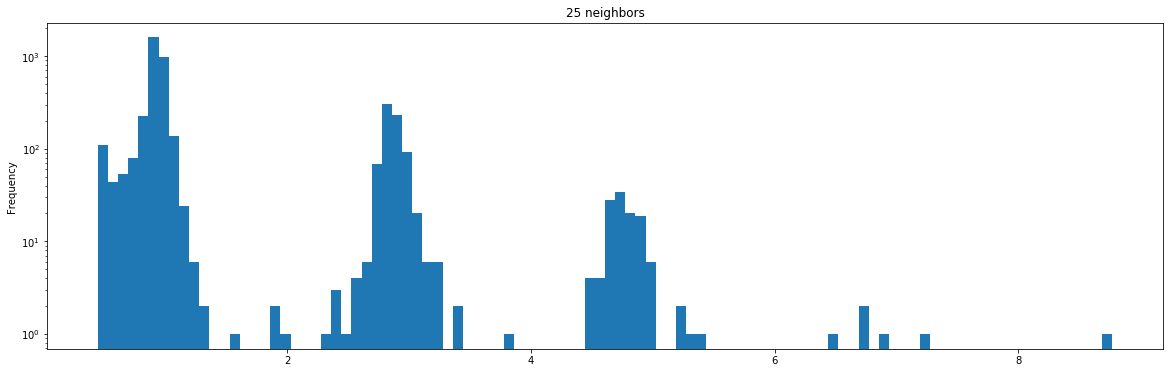

In [96]:
df = dfs['256']

for n in sorted(df['n_neighbors'].unique()):
    mask = (df['n_neighbors'] == n)
    
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    df[mask]['edges_getmem'].plot(kind = 'hist', bins = 100, ax = ax, title = str(n) + ' neighbors', logy = True)

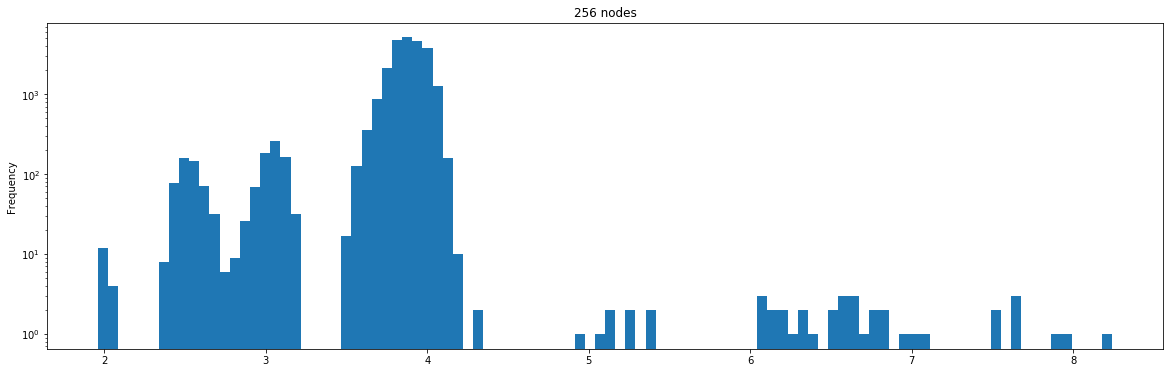

In [86]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['edges_updates'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes', logy = True)

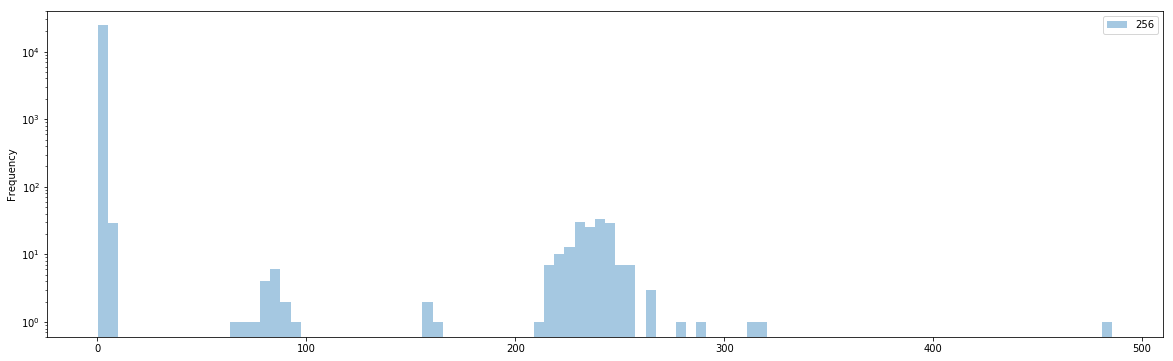

In [87]:
series = {}
for nnodes in sorted(dfs.keys()):
    series[nnodes] = dfs[nnodes]['edges_getmem']
   
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
pd.DataFrame(series).plot(kind = 'hist', bins = 100, ax = ax, logy = True, alpha = 0.4)
#for nnodes in sorted(dfs.keys()):
#    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
#    dfs[nnodes]['edges_getmem'].plot(kind = 'hist', bins = 100, ax = ax,
#                                     title = str(nnodes) + ' nodes', logy = True, xlim = (0, 200))

In [89]:
for nnodes in sorted(dfs.keys()):
    print(nnodes + '\t-\t' + str(dfs[nnodes]['edges_getmem'].sum()))

256	-	67032.667


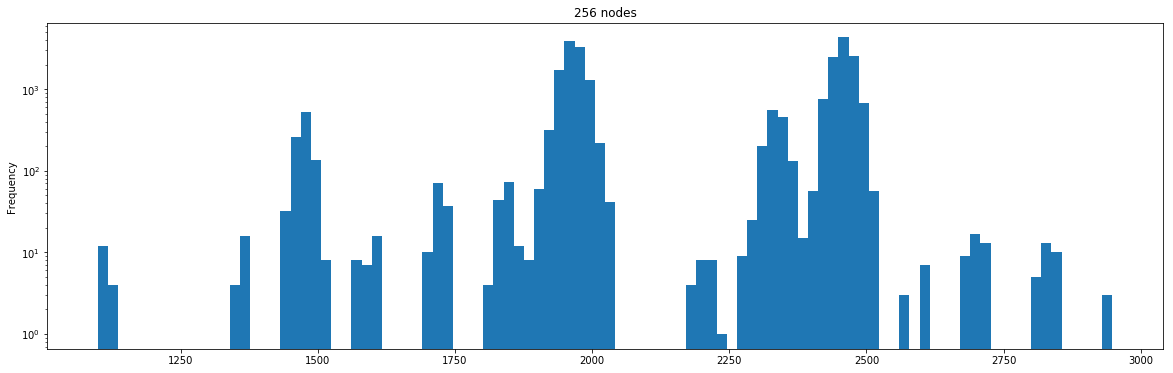

In [88]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['edges_checks'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes', logy = True)

In [27]:
# 4x as many local vertices for 8 nodes
for nnodes in sorted(dfs.keys()):
    print(nnodes + '\t' + str(dfs[nnodes]['edges_checks'].sum()))

32	86284919.0
8	51143917.0


In [15]:
dfs['new'].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges',
       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
       u'summary_actor_partitions', u'summary_time_window',
       u'summary_update_neighbors', u'summary_update_neighbors_body',
       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
       u'total'],
      dtype='object')

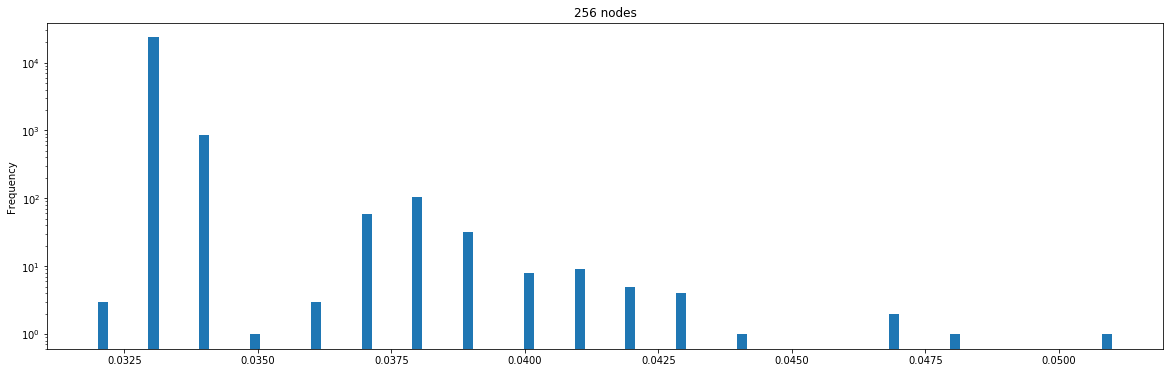

In [16]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['coupling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

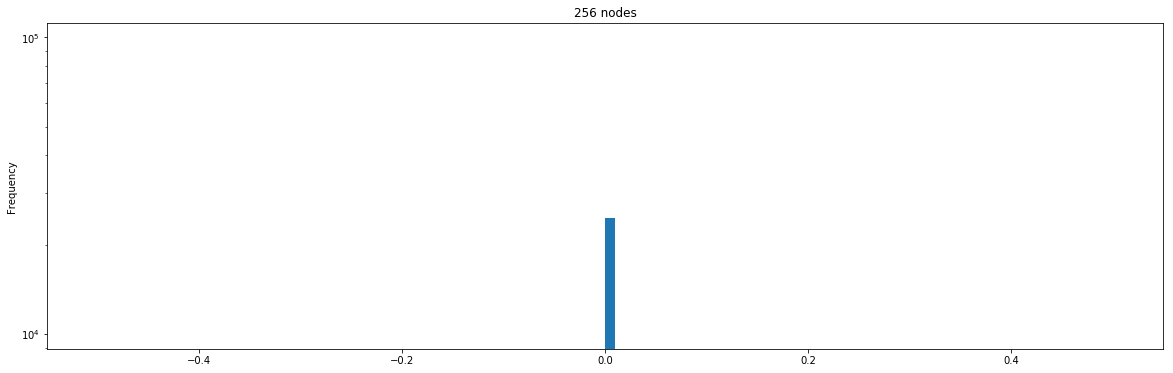

In [17]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['n_coupled_spins'].plot(kind = 'hist', bins = 100, ax = ax,
                                title = str(nnodes) + ' nodes', logy = True)

In [11]:
dfs['new'].sort_values(by = 'coupling', ascending = False)

,active_partitions,cache_age_misses,cache_hits,cache_misses,coupled_values,coupling,edges,edges_getmem,edges_updates,metadata,...,summary_actor_partitions,summary_time_window,summary_update_neighbors,summary_update_neighbors_body,summary_update_neighbors_getmem,summary_update_neighbors_lock,summary_update_neighbors_unlock,throttling,timestep,total
22130,171,78498,339757,1198,0.016,0.017,82.592,25.071,56.492,1.254,...,0.300,0.024,2.243,1.115,0.318,0.448,0.361,0.019,340,86.563
26539,169,109110,375514,1011,0.017,0.017,83.766,35.884,47.477,1.306,...,0.336,0.020,1.922,1.173,0.246,0.278,0.223,0.013,457,87.510
56377,166,277160,784988,1087,0.018,0.017,70.791,21.800,48.191,1.319,...,0.289,0.021,2.199,1.169,0.333,0.385,0.307,0.020,946,74.777
6541,167,23072,100233,1034,0.016,0.016,70.547,20.323,49.692,1.231,...,0.283,0.024,2.003,1.182,0.278,0.297,0.239,0.024,116,74.245
14617,171,49222,227727,1197,0.016,0.016,83.414,25.709,56.714,1.322,...,0.303,0.020,2.159,1.135,0.302,0.386,0.331,0.020,226,87.371
5583,167,16908,89272,1168,0.017,0.016,78.644,22.181,55.503,1.166,...,0.260,0.020,2.322,1.128,0.365,0.480,0.345,0.020,88,82.562
23989,169,93320,343440,1011,0.018,0.016,71.480,22.972,47.946,1.400,...,0.349,0.023,2.106,1.169,0.295,0.349,0.286,0.015,412,75.513
63070,170,213824,1009814,1222,0.017,0.016,76.177,22.236,53.043,1.265,...,0.167,0.018,2.030,1.116,0.283,0.337,0.292,0.021,962,79.799
45242,166,194486,635734,1076,0.017,0.015,73.213,24.196,48.336,1.116,...,0.247,0.020,2.225,1.144,0.315,0.420,0.342,0.036,747,76.991
36364,168,179705,500887,1186,0.016,0.015,81.897,26.132,54.763,1.362,...,0.332,0.023,2.120,1.148,0.280,0.371,0.321,0.020,556,85.877


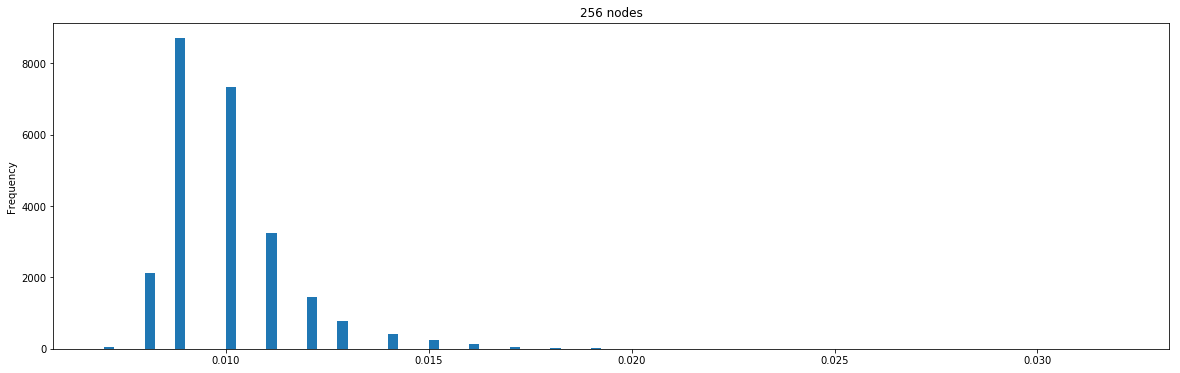

In [18]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['coupled_values'].plot(kind = 'hist', bins = 100, ax = ax,
                                title = str(nnodes) + ' nodes')

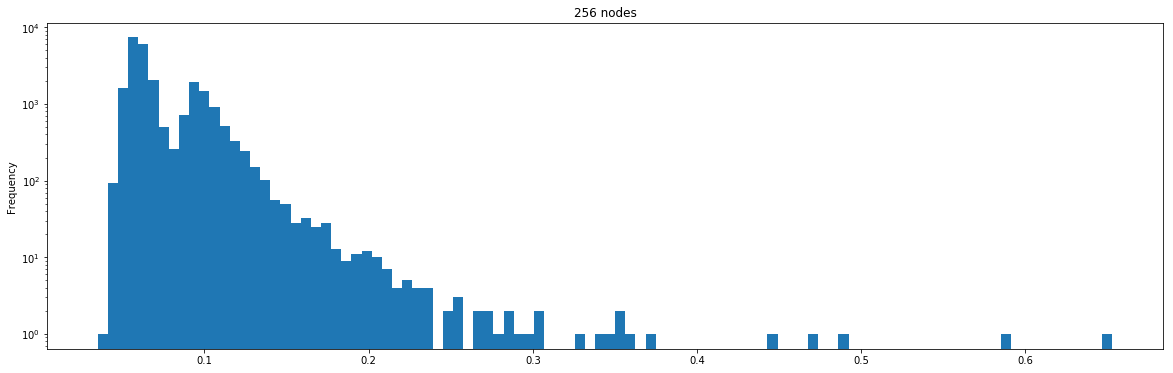

In [19]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['throttling'].plot(kind = 'hist', bins = 100, ax = ax,
                                title = str(nnodes) + ' nodes', logy = True)

In [14]:
# Who does the most throttling and least throttling?
dfs['new'].sort_values(by = 'throttling')[['throttling', 'pe', 'timestep']].head(10)

,throttling,pe,timestep
12731,0.011,63,214
34051,0.011,63,590
45560,0.012,63,793
44244,0.012,63,770
33823,0.012,63,586
5968,0.012,63,90
27779,0.012,63,479
22361,0.012,63,384
24955,0.012,63,429
50107,0.012,63,874


In [15]:
# Who does the most throttling and least throttling?
dfs['new'].sort_values(by = 'throttling', ascending = False)[['throttling', 'pe', 'timestep', 'spins']].head(10)

,throttling,pe,timestep,spins
50104,0.118,12,741,0
52233,0.091,50,799,0
56041,0.087,50,830,0
4065,0.077,5,47,0
37574,0.077,51,581,0
15478,0.076,20,237,0
47929,0.075,2,778,0
58281,0.074,20,873,0
39883,0.074,2,647,0
16526,0.074,36,255,0


In [ ]:
# Who are the slowest PEs?
df = dfs['new']
u = df[df['total'] > 55.0]['pe'].unique()
u.sort()
u

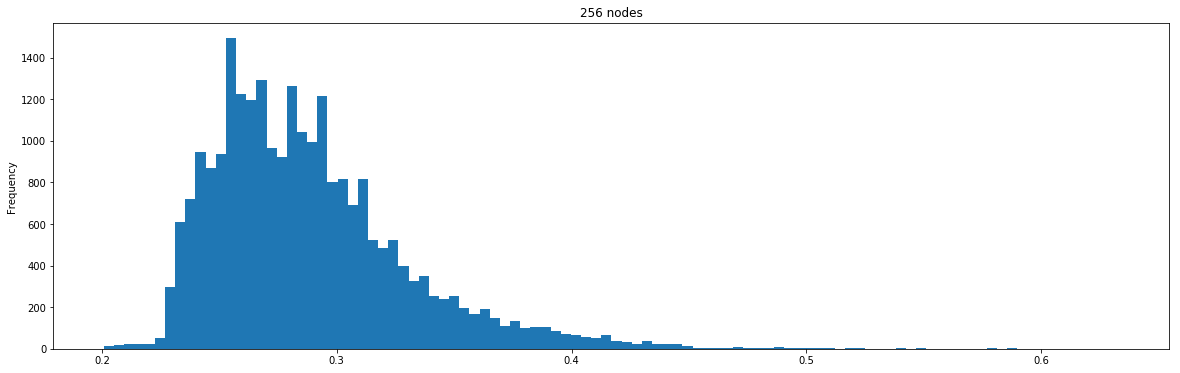

In [20]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['neighbor_updates'].plot(kind = 'hist', bins = 100, ax = ax,
                                title = str(nnodes) + ' nodes')

In [ ]:
dfs['new']['coupling'].min()

In [22]:
# 47, 48 do more throttling than 0, 255. However, they appear to only do this throttling
# very, very early in the simulation (around timestep 10) but when they do it, it is
# significant (>2 seconds).
interesting_pes = [0, 255, 47, 48]

df = dfs['256']
interesting_dfs = {}
for pe in interesting_pes:
    interesting_dfs[pe] = df[df['pe'].isin([pe])].sort_values(by = 'timestep')

In [23]:
interesting_dfs[interesting_pes[0]].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges',
       u'edges_checks', u'edges_getmem', u'edges_updates', u'metadata',
       u'n_coupled_spins', u'n_neighbors', u'neighbor_updates', u'nquiets',
       u'pe', u'spins', u'summary', u'summary_actor_partitions',
       u'summary_time_window', u'summary_update_neighbors',
       u'summary_update_neighbors_body', u'summary_update_neighbors_getmem',
       u'summary_update_neighbors_lock', u'summary_update_neighbors_unlock',
       u'throttling', u'timestep', u'total'],
      dtype='object')

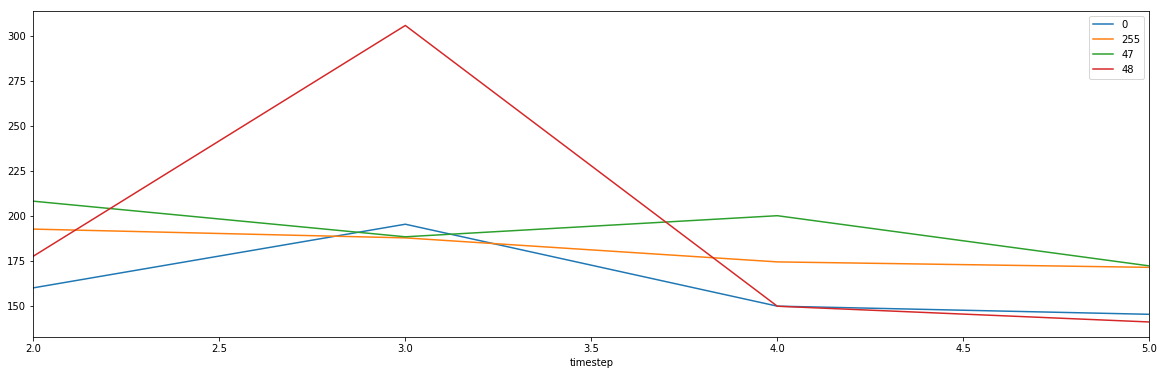

In [24]:
def plot_for_metric(metric):
    len_shortest_df = 90
    
    d = {'timestep': interesting_dfs[interesting_pes[0]]['timestep'].values[:len_shortest_df]}
    for pe in interesting_pes:
        d[str(pe)] = interesting_dfs[pe][metric].values[:len_shortest_df]
    
    pd.DataFrame(d).plot(kind = 'line', x = 'timestep', figsize = (20.0, 6.0))

plot_for_metric('total')

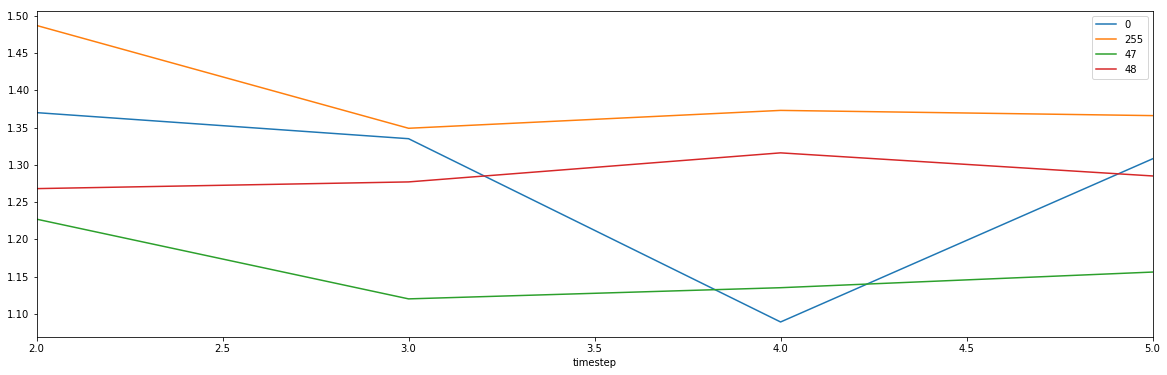

In [25]:
plot_for_metric('metadata')

In [ ]:
# 'coupled_values', 'coupling', 'edges', 'neighbor_updates', 'summary', 'throttling'
plot_for_metric('coupled_values')

In [ ]:
plot_for_metric('coupling')

In [ ]:
plot_for_metric('n_coupled_spins')

In [ ]:
plot_for_metric('edges')

In [ ]:
plot_for_metric('edges_updates')

In [ ]:
plot_for_metric('edges_getmem')

In [ ]:
plot_for_metric('edges_getmem')

In [ ]:
plot_for_metric('neighbor_updates')

In [ ]:
plot_for_metric('summary')

In [ ]:
plot_for_metric('summary_actor_partitions')

In [ ]:
plot_for_metric('summary_time_window')

In [ ]:
plot_for_metric('summary_update_neighbors')

In [ ]:
plot_for_metric('summary_update_neighbors_lock')

In [ ]:
plot_for_metric('summary_update_neighbors_getmem')

In [ ]:
plot_for_metric('summary_update_neighbors_unlock')

In [ ]:
plot_for_metric('n_neighbors')

In [ ]:
def compute_mean(metric):
    d = {}
    for pe in interesting_pes:
        d[pe] = interesting_dfs[pe][metric].mean()
    return d

compute_mean('n_neighbors')

In [ ]:
plot_for_metric('summary_update_neighbors_body')

In [ ]:
plot_for_metric('throttling')

In [ ]:
#[u'active_partitions', u'cache_age_misses', u'cache_hits',
#       u'cache_misses', u'coupled_values', u'coupling', u'edges',
#       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
#       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
#       u'summary_actor_partitions', u'summary_time_window',
#      u'summary_update_neighbors', u'summary_update_neighbors_body',
#       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
#       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
#       u'total']
plot_for_metric('throttling')